<a href="https://colab.research.google.com/github/botastark/CV/blob/main/VPproject_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd

In [ ]:
#Utilities


def verify_str(value, valid):
  assert value in valid
  return valid.index(value)

splits = ['train', 'dev','test']
classes = ['gender', 'status']
class_names = ['noable','worrior','incarnation','commone']


def image_loader(path):
    path = os.path.join(root, 'images_256',path)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return np.asarray(img)
        

In [ ]:
import csv
def load_data(path, split, class_by):
  split = verify_str(split, splits)
  class_by = verify_str(class_by, classes)
  progress_bar = tqdm()
  labels = []
  images = []
  count=0
  with open(path) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')
      missed_images = []
      #skip header [image, gender,, status, set]
      next(csv_reader)
      for i, row in enumerate(csv_reader):

        #skip if entry belongs to a wrong split(train, dev, test)
        if row[3]!=splits[split]:
          continue
        #verify that image exists in a folder
        if os.path.exists(os.path.join(root, 'images_256', row[0]))==False:
          missed_images.append(row[0])
          continue

        labels.append(int(row[class_by+1]))
        images.append(image_loader(row[0]))

        progress_bar.update()
        if i % 1_000 == 0:
            progress_bar.set_postfix_str(s=str(len(labels)), refresh=True)
  progress_bar.close()
  print(f'Processed {len(images)} lines for {splits[split]}')
  if len(missed_images)>0:
    print(f'{len(missed_images)} images are missing: {missed_images}')
  return np.array(labels),np.array(images)   #.reshape(-1,1)   

In [ ]:
#Load dataset 4238 samples for train
import os
data_location = '/content/drive/MyDrive/Colab Notebooks/kaokore-master/kaokore'
root = os.path.expanduser(data_location)


train_label, train_images = load_data(os.path.join(root, 'labels.csv'),'train','status')
print(train_label.shape)
print(train_images.shape)

0it [00:00, ?it/s]

Processed 4238 lines for train
(4238,)
(4238, 256, 256, 3)


In [ ]:
# print(train_label.shape)
test_labels, test_images = load_data(os.path.join(root, 'labels.csv'),'test','status')

train_label_one_hot= np.array(pd.get_dummies(train_label))
test_label_one_hot= np.array(pd.get_dummies(test_labels))



0it [00:00, ?it/s]

Processed 527 lines for test


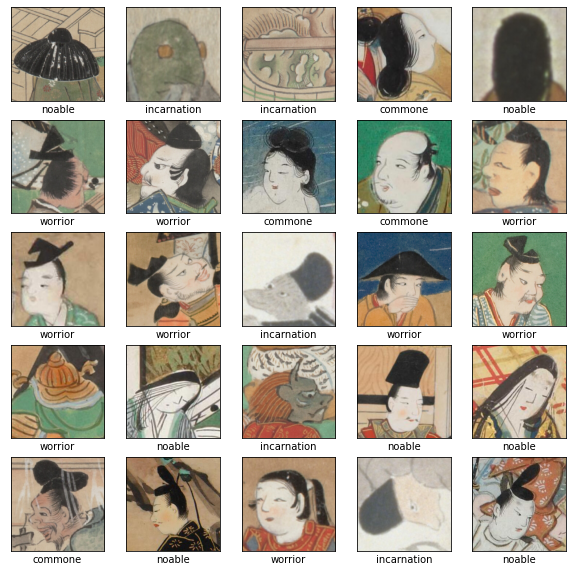

In [ ]:
#Visualise first 25 images with labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(0,25):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    plt.xlabel(class_names[int(train_label[i])])
plt.show()

In [ ]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(96, [4,4], strides=(4, 4), padding= 'same')(input_img)#96
    ## RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(128, [4,4], strides=(2, 2), padding= 'same')(P1)
    ## RELU
    A2 = tf.keras.layers.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same')(A2)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z3 = tf.keras.layers.Conv2D(256, [4,4], strides=(2, 2), padding= 'same')(P2)
    ## RELU
    A3 = tf.keras.layers.ReLU()(Z3)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same')(A3)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z4 = tf.keras.layers.Conv2D(512, [4,4], strides=(2, 2), padding= 'same')(P3)
    ## RELU
    A4 = tf.keras.layers.ReLU()(Z4)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same')(A4)
    ## FLATTEN
    F = tf.keras.layers.Flatten()(P4)
    ## Dense layer
    ## 4 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tf.keras.layers.Dense(4, activation='softmax')(F)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
conv_model = convolutional_model(train_images[0].shape)
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
re_lu_23 (ReLU)              (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
re_lu_24 (ReLU)              (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 128)       0   

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_label_one_hot)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_label_one_hot)).batch(64)
history = conv_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
67/67 [==============================] - 270s 4s/step - loss: 0.8295 - accuracy: 0.6630 - val_loss: 0.8135 - val_accuracy: 0.6888
Epoch 2/10
67/67 [==============================] - 270s 4s/step - loss: 0.7564 - accuracy: 0.6907 - val_loss: 0.8485 - val_accuracy: 0.6509
Epoch 3/10
67/67 [==============================] - 268s 4s/step - loss: 0.7429 - accuracy: 0.6954 - val_loss: 0.8129 - val_accuracy: 0.6774
Epoch 4/10
67/67 [==============================] - 271s 4s/step - loss: 0.7159 - accuracy: 0.7133 - val_loss: 0.8178 - val_accuracy: 0.6964
Epoch 5/10
67/67 [==============================] - 271s 4s/step - loss: 0.6911 - accuracy: 0.7194 - val_loss: 0.7915 - val_accuracy: 0.6755
Epoch 6/10
67/67 [==============================] - 271s 4s/step - loss: 0.6247 - accuracy: 0.7496 - val_loss: 0.8843 - val_accuracy: 0.6660
Epoch 7/10
67/67 [==============================] - 271s 4s/step - loss: 0.5709 - accuracy: 0.7754 - val_loss: 0.9800 - val_accuracy: 0.6452
Epoch 8/10
67

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

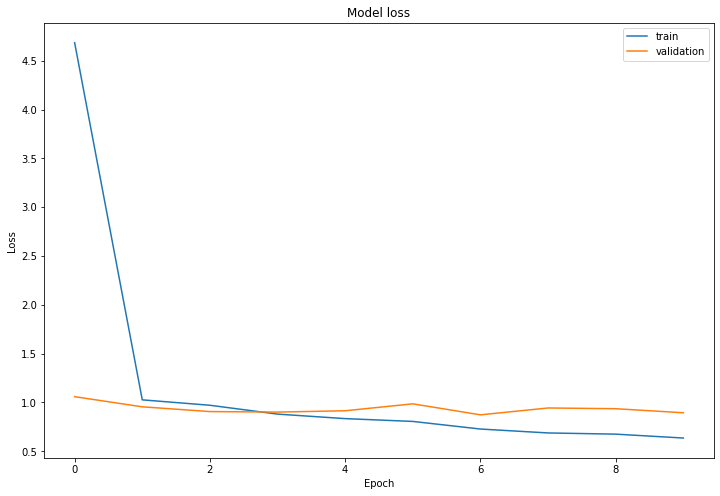

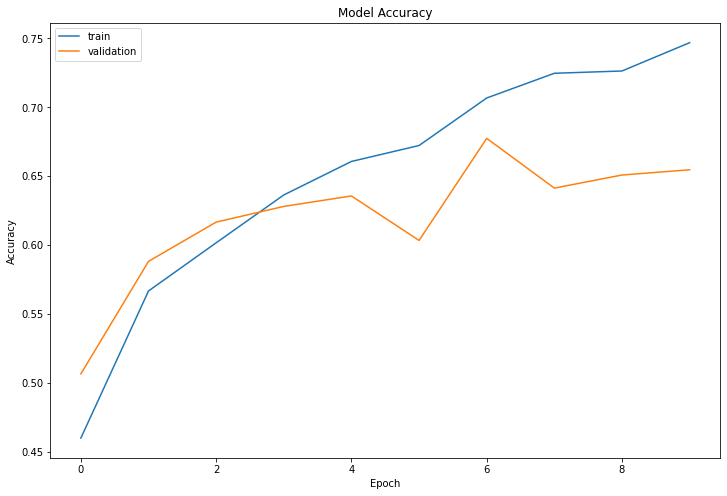

In [ ]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
print(im.size)
print(im.size[0])
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(im.size[0], im.size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_label, epochs=10, 
                    validation_data=(test_images, test_labels))